## CNN

### CIFAR10 dataset classifications problem

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def get_data_loaders(batch_size = 64):
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(((0.5, 0.5, 0.5)), (0.5, 0.5, 0.5))
        ])
    
    train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [20]:
def imshow(img):
    img = (img / 2) + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In [21]:
def get_sample_images(train_loader):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    return images, labels

100%|██████████| 170M/170M [00:57<00:00, 2.97MB/s] 


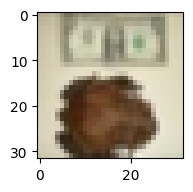

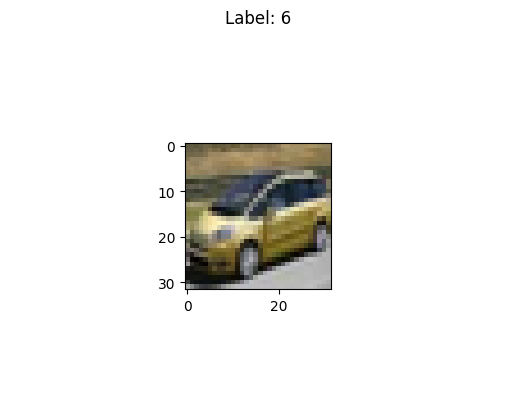

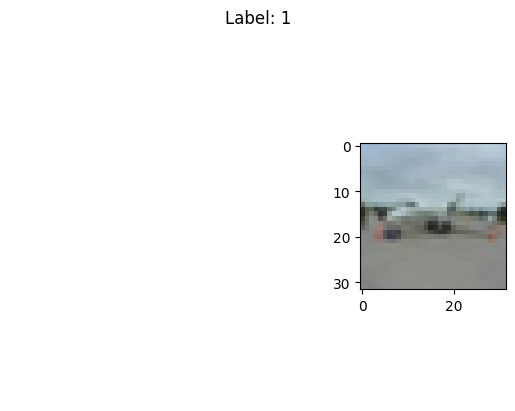

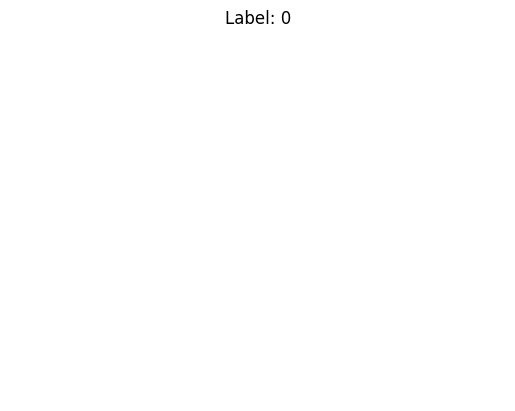

In [22]:
def visualize(n):
    train_loader, test_loader = get_data_loaders(batch_size=64)

    images, labels = get_sample_images(train_loader=train_loader)
    plt.figure()
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

visualize(3)

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.dropout = nn.Dropout(p=0.2)

        self.flatten  = nn.Flatten()

        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
def train_model(model, train_loader, loss_fn, optimizer, epochs=5):
    model.train()
    train_loss = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_loss.append(avg_loss)
        print(f"Epoch: {epoch + 1} / {epochs}, Loss: {avg_loss:.5f}")
    
    plt.figure()
    plt.plot(range(1, epochs + 1), train_loss, marker = "o", linestyle="-", label="Train loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training loss")
    plt.legend()
    plt.show()

In [33]:
train_loader, test_loader = get_data_loaders(batch_size=64)

In [34]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=1e-3, momentum = 0.9)

Epoch: 1 / 5, Loss: 1.29855
Epoch: 2 / 5, Loss: 1.24256
Epoch: 3 / 5, Loss: 1.19008
Epoch: 4 / 5, Loss: 1.14119
Epoch: 5 / 5, Loss: 1.09693


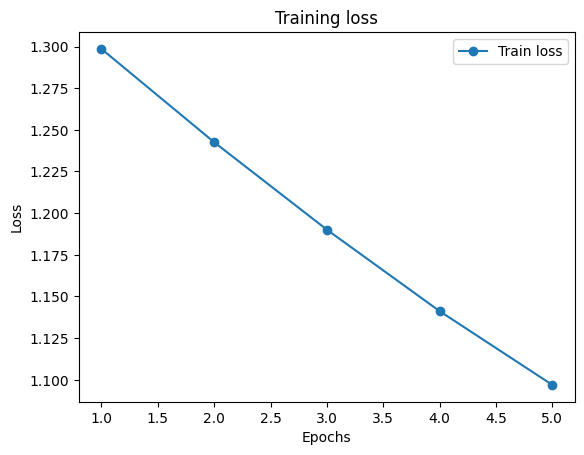

In [36]:
train_model(model=model, train_loader=train_loader, loss_fn=loss_fn, optimizer=optimizer)

In [45]:
def test_model(model, test_loader, dataset_type):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predict = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()

    print(f"{dataset_type} accuracy: {100 * correct / total}%")

In [46]:
# test accuracy
test_model(model=model, test_loader=test_loader,dataset_type="training")

training accuracy: 61.97%


In [47]:
# train accuracy
test_model(model=model, test_loader=train_loader,dataset_type="test")

test accuracy: 64.562%


Epoch: 1 / 5, Loss: 2.05529
Epoch: 2 / 5, Loss: 1.71101
Epoch: 3 / 5, Loss: 1.53612
Epoch: 4 / 5, Loss: 1.41897
Epoch: 5 / 5, Loss: 1.33199


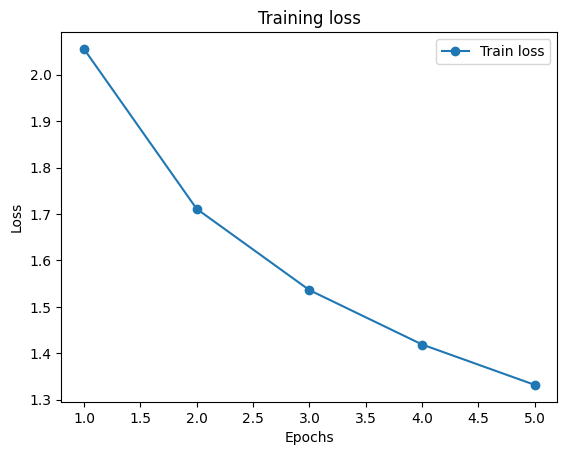

training accuracy: 54.9%
test accuracy: 55.384%


In [50]:
if __name__ == '__main__':
    train_loader, test_loader = get_data_loaders(batch_size=64)
    deivce = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN().to(device)
    optimizer = optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    train_model(model=model, train_loader=train_loader, loss_fn=loss_fn, optimizer=optimizer)
    # test accuracy
    test_model(model=model, test_loader=test_loader,dataset_type="training")
    # train accuracy
    test_model(model=model, test_loader=train_loader,dataset_type="test")